# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



Imports 

In [206]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage 

# Reshaping the data

In [207]:
df = pd.read_excel("alldata.xlsx")
df.columns

Index(['530', '531', '533', '534', '535', '537', '538', '540', '541', '543',
       '544', '545', '546', '547', '548', '550', '551', '552', '553', '555',
       '556', '557', '559', '561', '563', 'navn', 'parti', '1a', '1b', '2a',
       '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', '7a', '7b', '8a',
       '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b', 'storkreds',
       'alder'],
      dtype='object')

In [208]:
# We need to rename the columns to combine these two dataframes

drq = pd.read_excel("drq.xlsx")
print(drq.columns)
tv2q = pd.read_excel("tv2q.xlsx")
print(tv2q.columns)

Index(['ID', 'Title', 'Question', 'Info', 'ArgumentFor', 'ArgumentAgainst',
       'WordMerger', 'ID_CandidateQuestionType', 'Rule', 'QuestionListData'],
      dtype='object')
Index(['id', 'type', 'header', 'question', 'depends'], dtype='object')


In [209]:
# The tv2's 'type' doesn't tell us anything as it only has one value
print(tv2q['type'].unique(), "\n")
# Therefore we'll merge the Titles and headers as they seem similar enough
print(drq['Title'].unique())
print(tv2q['header'].unique())

['rate'] 

['KLIMA OG ENERGI' 'ARBEJDSMARKED OG ØKONOMI' 'RET OG STRAF'
 'EU OG UDENRIGS' 'VELFÆRD' 'UDDANNELSE' 'DEMOKRATI' 'SUNDHED']
['Bornholms Storkreds' 'Fyns Storkreds' 'Københavns Omegns Storkreds'
 'Københavns Storkreds' 'Nordjyllands Storkreds' 'Nordsjællands Storkreds'
 'Sjællands Storkreds' 'Sydjyllands Storkreds' 'Vestjyllands Storkreds'
 'Østjyllands Storkreds' 'Miljø og klima' 'Hospitaler og sundhed'
 'Udenrigs- og forsvarspolitik' 'Økonomi' 'Ældre'
 'Flygtninge og indvandrere' 'Energipolitik' 'Børn og unge'
 'Skole og uddannelse' 'Socialområdet' 'Mink-sagen' 'Coronavirus']


In [210]:
# Renaming columns
drq.rename(columns={
    "ID": "id",
    "Title": "header",
    "Question": "question"
}, inplace=True)

# Dropping unnecessary columns
drq.drop(columns=['Info', 'ArgumentFor', 'ArgumentAgainst', 
          'WordMerger', 'ID_CandidateQuestionType', 'Rule', 'QuestionListData'], inplace=True)

tv2q.drop(columns=['type', 'depends'], inplace=True)

In [211]:
# Union the two dataframes
questions = pd.concat([drq, tv2q])

In [212]:
# Translate the headers to english
# We have tried using APIs for translation but they didn't work well, so we did it manually

danish_headers = [
    "KLIMA OG ENERGI",
    "ARBEJDSMARKED OG ØKONOMI",
    "RET OG STRAF",
    "EU OG UDENRIGS",
    "VELFÆRD",
    "UDDANNELSE",
    "DEMOKRATI",
    "SUNDHED",
    "Bornholms Storkreds",
    "Fyns Storkreds",
    "Københavns Omegns Storkreds",
    "Københavns Storkreds",
    "Nordjyllands Storkreds",
    "Nordsjællands Storkreds",
    "Sjællands Storkreds",
    "Sydjyllands Storkreds",
    "Vestjyllands Storkreds",
    "Østjyllands Storkreds",
    "Miljø og klima",
    "Hospitaler og sundhed",
    "Udenrigs- og forsvarspolitik",
    "Økonomi",
    "Ældre",
    "Flygtninge og indvandrere",
    "Energipolitik",
    "Børn og unge",
    "Skole og uddannelse",
    "Socialområdet",
    "Mink-sagen",
    "Coronavirus",
]
english_headers = [
    "CLIMATE AND ENERGY",
    "LABOR MARKET AND ECONOMY",
    "JUSTICE AND PUNISHMENT",
    "EU AND FOREIGN AFFAIRS",
    "WELFARE",
    "EDUCATION",
    "DEMOCRACY",
    "HEALTH",
    "Bornholm Greater Constituency",
    "Funen Greater Constituency",
    "Copenhagen Greater Constituency",
    "Copenhagen Greater Constituency",
    "Northern Jutland Greater Constituency",
    "North Zealand Greater Constituency",
    "Zealand Greater Constituency",
    "Southern Jutland Greater Constituency",
    "West Jutland Greater Constituency",
    "Eastern Jutland Greater Constituency",
    "Environment and Climate",
    "Hospitals and Health",
    "Foreign and Defense Policy",
    "Economy",
    "Elderly",
    "Refugees and Immigrants",
    "Energy Policy",
    "Children and Youth",
    "School and Education",
    "Social Affairs",
    "Mink Case",
    "Coronavirus",
]

header_mapping = {}

for index in range(len(danish_headers)):
    header_mapping[danish_headers[index]] = english_headers[index]

questions["header_eng"] = questions["header"].map(header_mapping)

In [213]:
df.drop(columns=['storkreds', 'alder'], inplace=True)

In [214]:
#Translate Party names to english

danish_parties = [
    "Moderaterne",
    "Socialistisk Folkeparti",
    "Alternativet",
    "Løsgænger",
    "Enhedslisten",
    "Danmarksdemokraterne",
    "Venstre",
    "Frie Grønne, Danmarks Nye Venstrefløjsparti",
    "Dansk Folkeparti",
    "Kristendemokraterne",
    "Liberal Alliance",
    "Nye Borgerlige",
    "Det Konservative Folkeparti",
    "Radikale Venstre",
    "Socialdemokratiet",
]
english_parties = [
    "Moderates",
    "Socialist People's Party",
    "The Alternative",
    "Independent",
    "Red–Green Alliance",
    "Denmark Democrats",
    "Danish Liberal Party",
    "Free Greens, Denmark's New Left Wing Party",
    "Danish People's Party",
    "Christian Democrats",
    "Liberal Alliance",
    "New Right",
    "Conservative People's Party",
    "Social Liberal Party",
    "Social Democrats",
]

parti_mapping = {}

for index in range(len(danish_parties)):
    parti_mapping[danish_parties[index]] = english_parties[index]

df["parti_english"] = df["parti"].map(parti_mapping)

In [215]:
# Dictionary of colors based on the party name
party_colors = {
    'Social Democrats': '#B32723',
    'Danish Liberal Party': '#006697',
    'Moderates': '#6C3AE5',
    "Socialist People's Party": '#DD0778',
    'Denmark Democrats': '#8AC3FF',
    'Liberal Alliance': '#20C6CF',
    "Conservative People's Party": '#9DBA27',
    'Red–Green Alliance': '#ED801A',
    'Social Liberal Party': '#713380',
    'New Right': '#054F5C',
    'The Alternative': '#2B8F39',
    "Danish People's Party": '#F3CD41',
    "Free Greens, Denmark's New Left Wing Party": '#01E66A',
    'Christian Democrats': '#BABABA',
    'Independent': '#000000',
}

df['color'] = df['parti'].map(party_colors)

In [216]:
party_leaders = {
    'Moderates': 'Lars Løkke Rasmussen',
    "Socialist People's Party": 'Pia Olsen Dyhr',
    'The Alternative': 'Franziska Rosenkilde',
    'Red–Green Alliance': 'Mai Villadsen',
    'Denmark Democrats': 'Inger Støjberg',
    'Danish Liberal Party': 'Jakob Ellemann-Jensen',
    "Free Greens, Denmark's New Left Wing Party": 'Uffe Elbæk',
    "Danish People's Party": 'Morten Messerschmidt',
    'Christian Democrats': 'Isabella Arendt',
    'Liberal Alliance': 'Alex Vanopslagh',
    'New Right': 'Pernille Vermund',
    "Conservative People's Party": 'Søren Pape Poulsen',
    'Social Liberal Party': 'Sofie Carsten Nielsen',
    'Social Democrats': 'Mette Frederiksen'
}

In [217]:
df['parti'].value_counts().describe()

count    15.000000
mean     57.800000
std      25.290314
min       3.000000
25%      42.000000
50%      67.000000
75%      72.000000
max      98.000000
Name: parti, dtype: float64

# Corelation Matrix

In [218]:
df.columns

Index(['530', '531', '533', '534', '535', '537', '538', '540', '541', '543',
       '544', '545', '546', '547', '548', '550', '551', '552', '553', '555',
       '556', '557', '559', '561', '563', 'navn', 'parti', '1a', '1b', '2a',
       '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', '7a', '7b', '8a',
       '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b',
       'parti_english', 'color'],
      dtype='object')

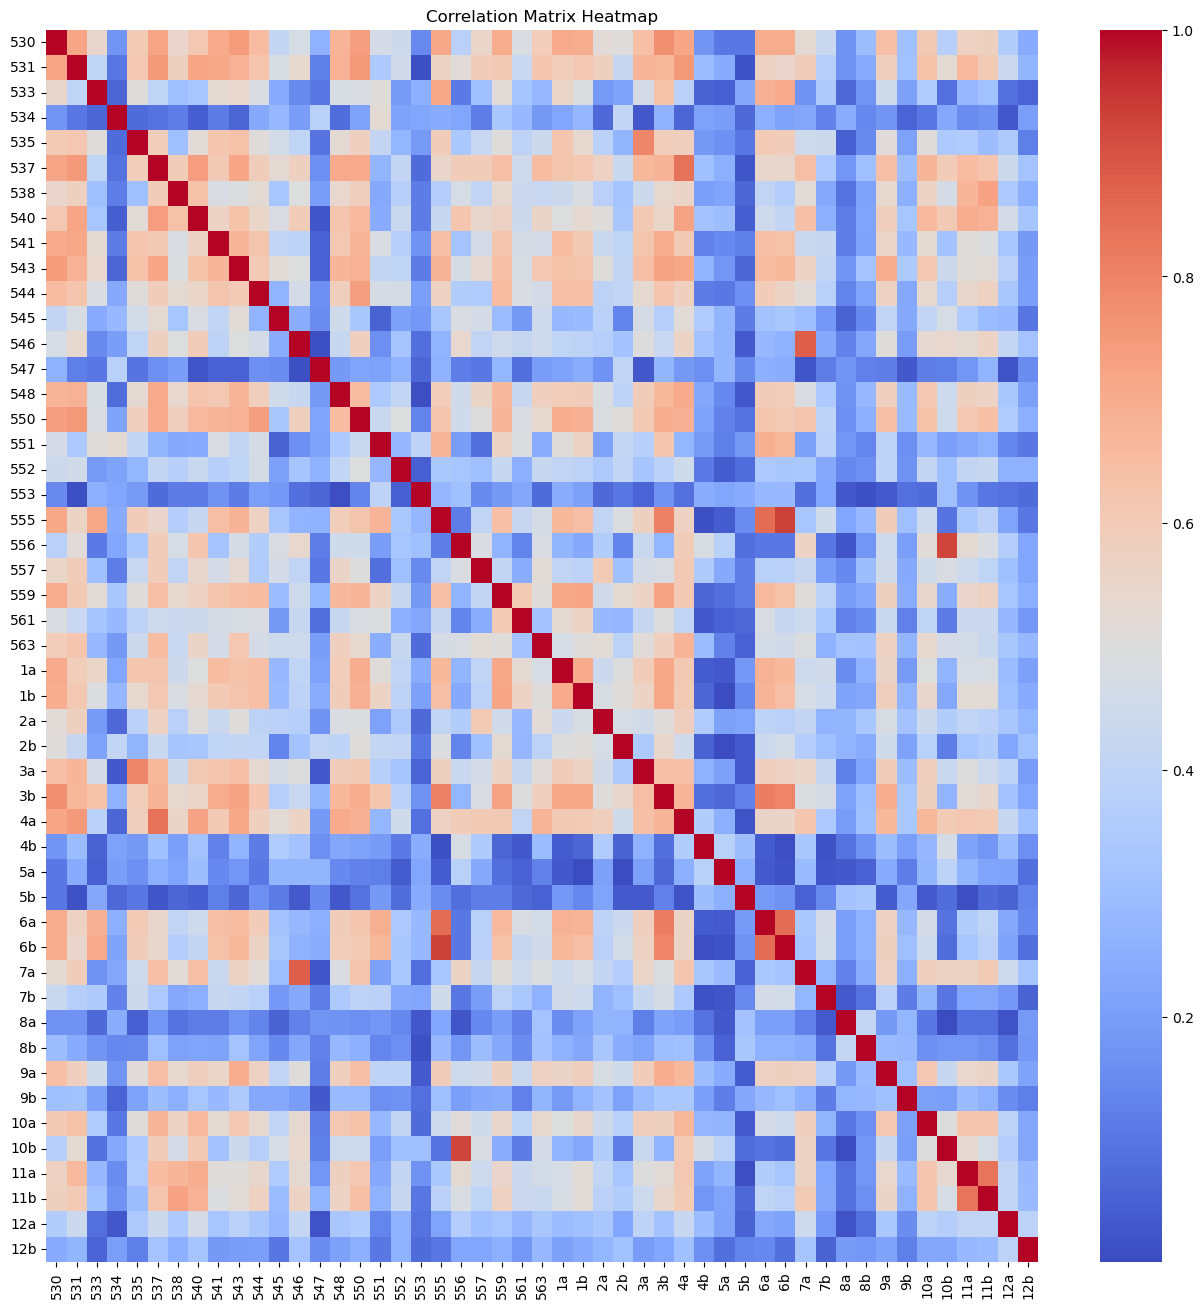

In [219]:
correlation_matrix = df.drop(columns=['navn', 'parti', 'parti_english', 'color']).corr().abs()

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

As we can see, there're some questions that have a high correlation with eachother, we can remove one of them to reduce overfitting

In [220]:
# Find features that have a high correlation with other features (we're going to drop these features)
threshold = 0.8

high_corr_pairs = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_pairs.add(colname)

display(high_corr_pairs)

{'10b', '11b', '3b', '4a', '6a', '6b', '7a'}

In [221]:
df.drop(columns=high_corr_pairs, inplace=True)

In [222]:
# Adding a mapping of the political spectrum

political_spectrum = {
    'Far-left': 0,
    'Left-wing': 1,
    'Centre-left': 2,
    'Centre-right': 3,
    'Right-wing': 4,
    'Far-right': 5,
    'Independent': None
}

party_positions = {
    'Social Democrats': 'Centre-left',
    'Danish Liberal Party': 'Centre-right',
    'Moderates': 'Centre-right',
    "Socialist People's Party": 'Left-wing',
    'Denmark Democrats': 'Right-wing',
    'Liberal Alliance': 'Right-wing',
    "Conservative People's Party": 'Right-wing',
    'Red–Green Alliance': 'Far-left',
    'Social Liberal Party': 'Centre-left',
    'New Right': 'Far-right',
    'The Alternative': 'Centre-left',
    "Danish People's Party": 'Far-right',
    "Free Greens, Denmark's New Left Wing Party": 'Centre-left',
    'Christian Democrats': 'Centre-right',
    'Independent': 'Independent'
}

df['party_position'] = df['parti_english'].map(lambda party: party_positions[party] if party in party_positions else None)
df['political_spectrum'] = df['parti_english'].map(lambda party: political_spectrum[party_positions[party]] if party in party_positions else None)

In [223]:
index = 0
mapping = {}
for parti in df['parti'].unique():
    mapping[parti] = index
    index += 1

df['parti_number'] = df['parti'].map(mapping)

In [224]:
# Initially, we only wanted to include questions that have a high correlation with the parti number,
# but we've discarted this idea as it didn't give us better results
# Instead we used further analysis

correlations = df.corr(numeric_only=True)['parti_number'].drop('parti_number')
print(len(correlations[abs(correlations) < 0.3]))
print(len(correlations[abs(correlations) > 0.3]))

28
15


In [225]:
#relevant_questions = correlations[abs(correlations) > 0.25].index
relevant_questions = correlations.index

In [226]:
X = df[relevant_questions]

In [227]:
X.columns

Index(['530', '531', '533', '534', '535', '537', '538', '540', '541', '543',
       '544', '545', '546', '547', '548', '550', '551', '552', '553', '555',
       '556', '557', '559', '561', '563', '1a', '1b', '2a', '2b', '3a', '4b',
       '5a', '5b', '7b', '8a', '8b', '9a', '9b', '10a', '11a', '12a', '12b',
       'political_spectrum'],
      dtype='object')

We will now analyse the relevant question answers for all parties based on the political spectrum to see if left and right spectrum differ on answers. For this we will look at the median answers for left and right parties.

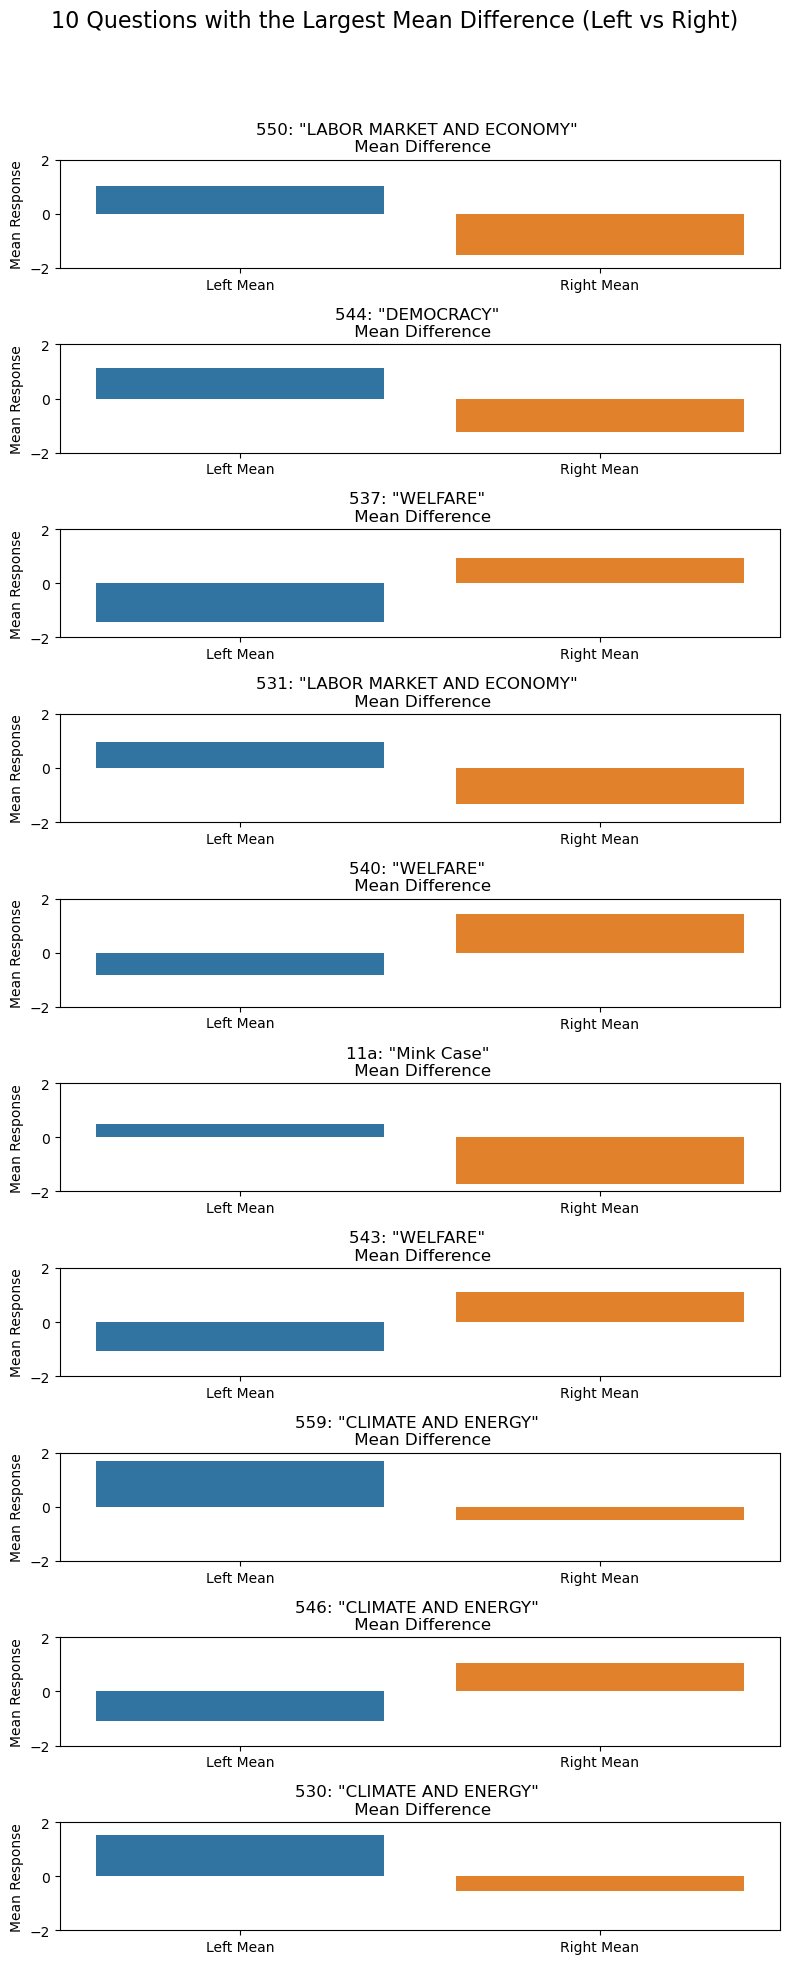

In [228]:
left_spectrum = df[df['political_spectrum'] <= 2].drop(columns=['navn', 'parti', 'parti_english', 'color', 'political_spectrum', 'parti_number'])
right_spectrum = df[df['political_spectrum'] >= 3].drop(columns=['navn', 'parti', 'parti_english', 'color', 'political_spectrum', 'parti_number'])

left_mean = left_spectrum.mean(numeric_only=True)
right_mean = right_spectrum.mean(numeric_only=True)

mean_differences = (left_mean - right_mean).abs()
top_questions = mean_differences.nlargest(10).index
weakest_questions = mean_differences.nsmallest(10).index

fig, axes = plt.subplots(nrows=len(top_questions), ncols=1, figsize=(8, 20))
fig.suptitle('10 Questions with the Largest Mean Difference (Left vs Right)', fontsize=16)

for i, question in enumerate(top_questions):
    header = questions[questions['id'].astype('string') == question]['header_eng'].values[0]

    sns.barplot(
        x=['Left Mean', 'Right Mean'], 
        y=[left_mean[question], right_mean[question]], 
        ax=axes[i]
    )
    
    axes[i].set_title(f'{question}: "{header}" \n Mean Difference')
    axes[i].set_ylabel('Mean Response')
    axes[i].set_ylim(-2, 2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

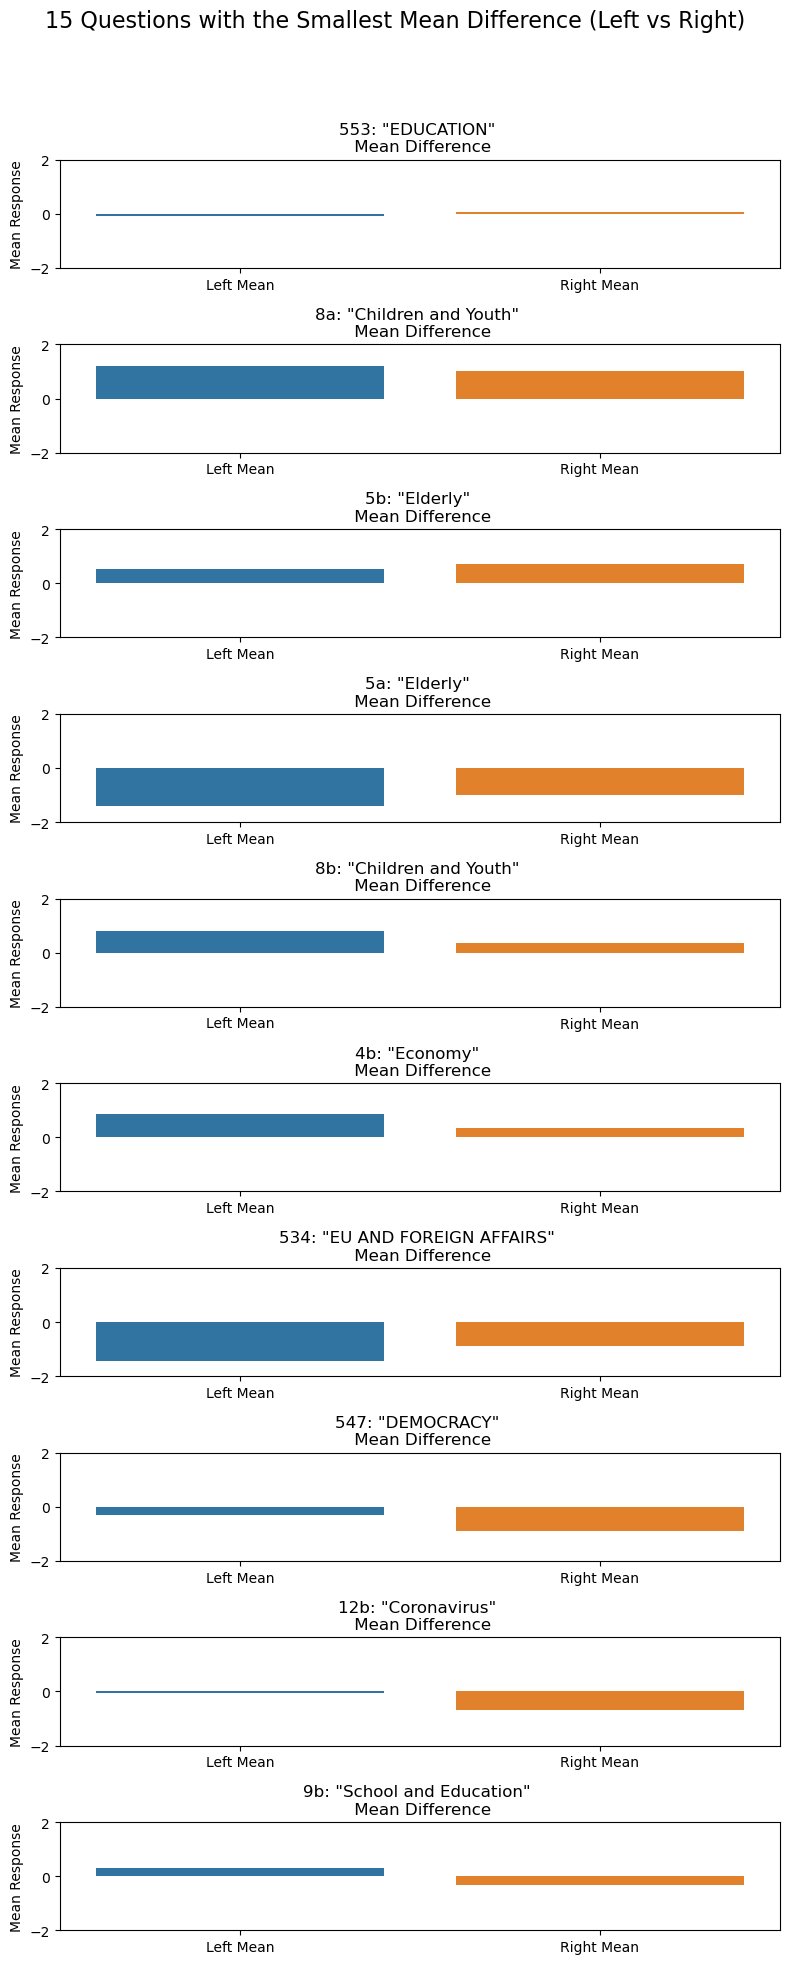

In [229]:
fig, axes = plt.subplots(nrows=len(weakest_questions), ncols=1, figsize=(8, 20))
fig.suptitle('15 Questions with the Smallest Mean Difference (Left vs Right)', fontsize=16)

for i, question in enumerate(weakest_questions):
    header = questions[questions['id'].astype('string') == question]['header_eng'].values[0]

    sns.barplot(
        x=['Left Mean', 'Right Mean'], 
        y=[left_mean[question], right_mean[question]], 
        ax=axes[i]
    )
    
    axes[i].set_title(f'{question}: "{header}" \n Mean Difference')
    axes[i].set_ylabel('Mean Response')

    axes[i].set_ylim(-2, 2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

It seems we can remove all of these questions apart from 12b, which seems to give some insight

In [230]:
weakest_questions = weakest_questions.to_list()
weakest_questions.remove('12b')

X.drop(columns=weakest_questions, inplace=True)

/var/folders/md/j2f882mn1vl7cb0f7l2mmkjh0000gp/T/ipykernel_5610/846321858.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=weakest_questions, inplace=True)


## PCA

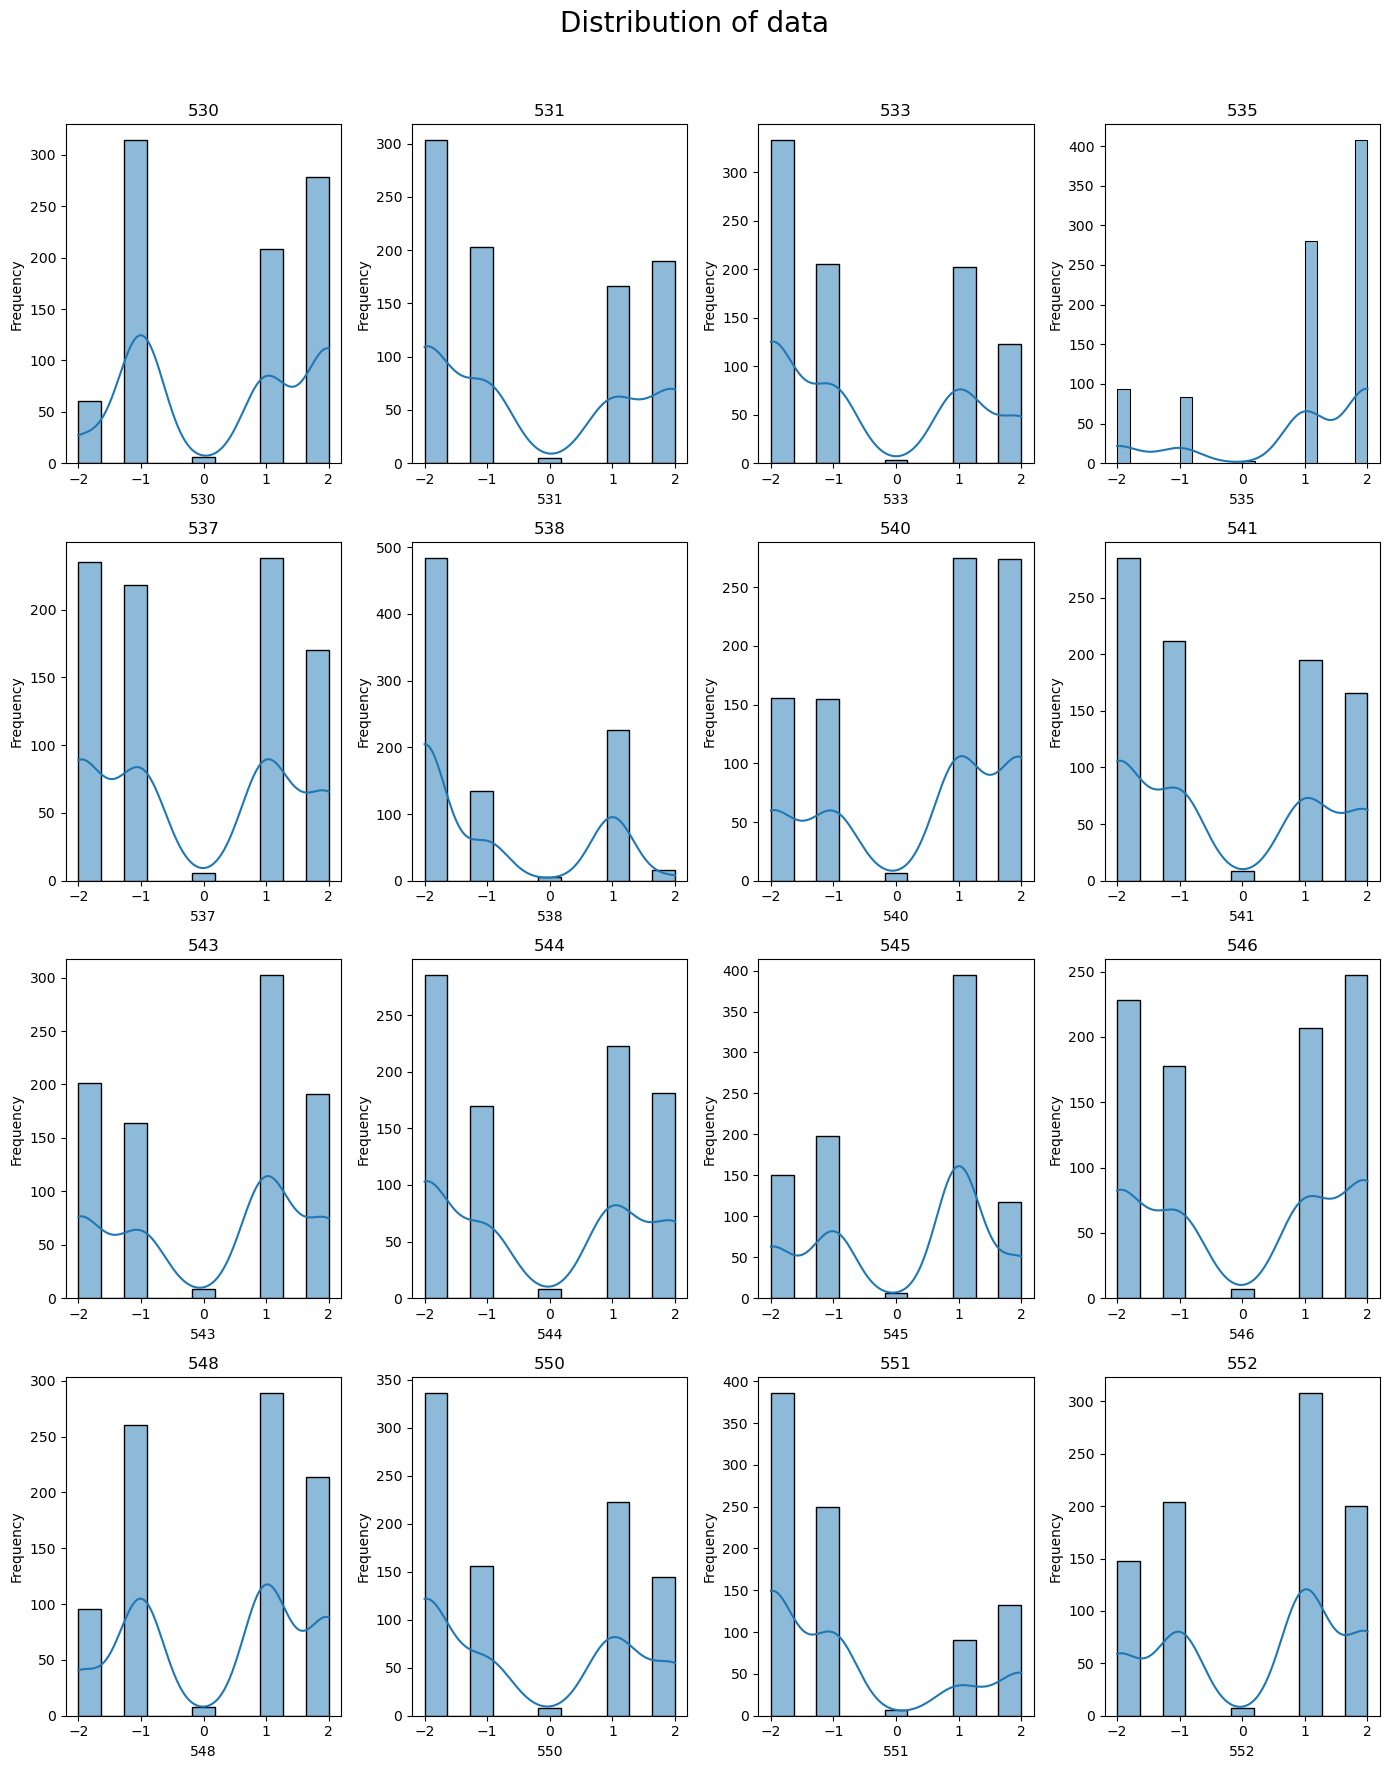

In [231]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 18))
fig.suptitle('Distribution of data', fontsize=20)
axes = axes.flatten()

X_temp = X.iloc[:, :16]

for i, column in enumerate(X_temp.columns):
    if column == 'political_spectrum':
        continue
    sns.histplot(X_temp[column], kde=True, ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Based on the histograms, we can see that the columns do not follow a gausian distribution and based on the fact that the numbers are in the range [-2, 2], we cannot use StandardScaler but we will use MinMaxScaler

In [232]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(X.drop(columns=['political_spectrum']))

In [233]:
pca = PCA().fit(data_scaled)
X_pca = range(1, len(pca.explained_variance_ratio_) + 1)
y_pca = np.cumsum(pca.explained_variance_ratio_)

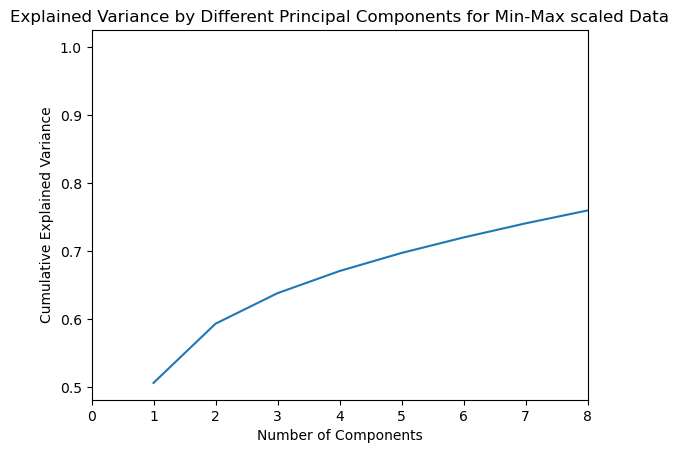

In [234]:
plt.figure()
plt.plot(X_pca, y_pca)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components for Min-Max scaled Data')
plt.xlim(0, 8)
plt.show()

From the shoulder plot, we can see that it bends after the second component, and doesn't change much afterwards. \
We'll use 2 components either way, since we need to plot the values, but later we're also going to compare using PCA with using all questions separately.

In [235]:
pca = PCA(n_components=2)

pca_results = pca.fit_transform(data_scaled)

In [236]:
display(pca.explained_variance_ratio_)

array([0.50592621, 0.08705266])

In [237]:
df['pca_1'] = pca_results[:, 0]
df['pca_2'] = pca_results[:, 1]

In [238]:
df.parti_english.unique()

array(['Moderates', "Socialist People's Party", 'The Alternative',
       'Independent', 'Red–Green Alliance', 'Denmark Democrats',
       'Danish Liberal Party',
       "Free Greens, Denmark's New Left Wing Party",
       "Danish People's Party", 'Christian Democrats', 'Liberal Alliance',
       'New Right', "Conservative People's Party", 'Social Liberal Party',
       'Social Democrats'], dtype=object)

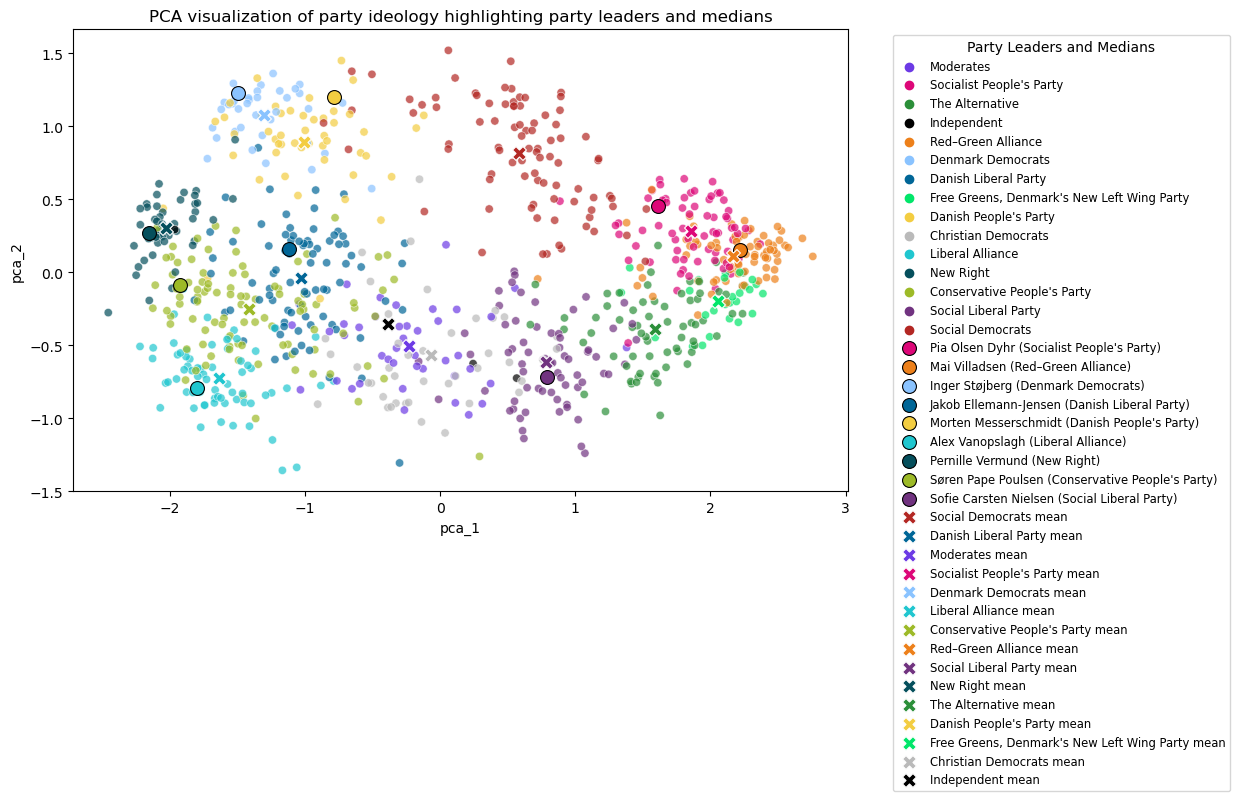

In [239]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='parti_english', data=df, palette=party_colors, alpha=0.7)
# Plot party leaders
for party, leader in party_leaders.items():
    leader_position = df[df['navn'] == leader][['pca_1', 'pca_2']]
    if not leader_position.empty:
        sns.scatterplot(x=leader_position['pca_1'], y=leader_position['pca_2'], color=party_colors[party], s=100, edgecolor='black', label=f'{leader} ({party})')

# Plot party mean positions
for party, color in party_colors.items():
    party_mean = df[df['parti_english'] == party][['pca_1', 'pca_2']].mean()
    sns.scatterplot(x=[party_mean['pca_1']], y=[party_mean['pca_2']], color=color, s=100, edgecolor='white', marker='X', label=f'{party} mean')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Party Leaders and Medians', fontsize='small')
plt.title('PCA visualization of party ideology highlighting party leaders and medians')
plt.show()


## t-SNE

As we can see on the two scatterplots below, T-sne has performed extremely well in comparison to PCA. Almost all parties have their own space in these two dimensions and party leaders seem to be at the center of their parties. 

In [240]:
tsne = TSNE(n_components=2, init='pca')
X_tsne = tsne.fit_transform(data_scaled)
rot = PCA(n_components=2)
X_tsne = rot.fit_transform(X_tsne)

In [241]:
df['tsne_1'] = X_tsne[:, 0]
df['tsne_2'] = X_tsne[:, 1]

/var/folders/md/j2f882mn1vl7cb0f7l2mmkjh0000gp/T/ipykernel_5610/3128891928.py:4: UserWarning: The palette list has more values (14) than needed (7), which may not be intended.
  sns.scatterplot(x='tsne_1', y='tsne_2', hue='party_position', data=df, palette=palette, alpha=0.6)


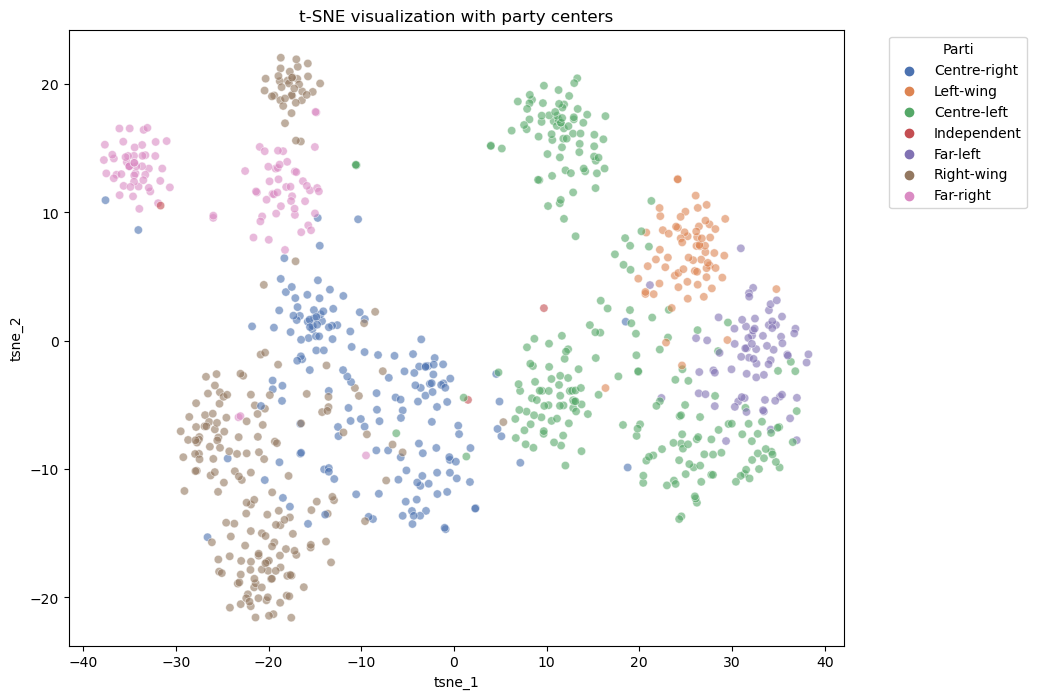

In [246]:
palette = sns.color_palette("deep", n_colors=14)

plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='party_position', data=df, palette=palette, alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Parti')
plt.title('t-SNE visualization with party centers')
plt.show()

As can be seen, T-sne has spread out the parties on x axis based on wether the parties consist of rightists or leftists. \
Funnily enough it's reversed, meaning that leftists are on the right and rightists are on the left.

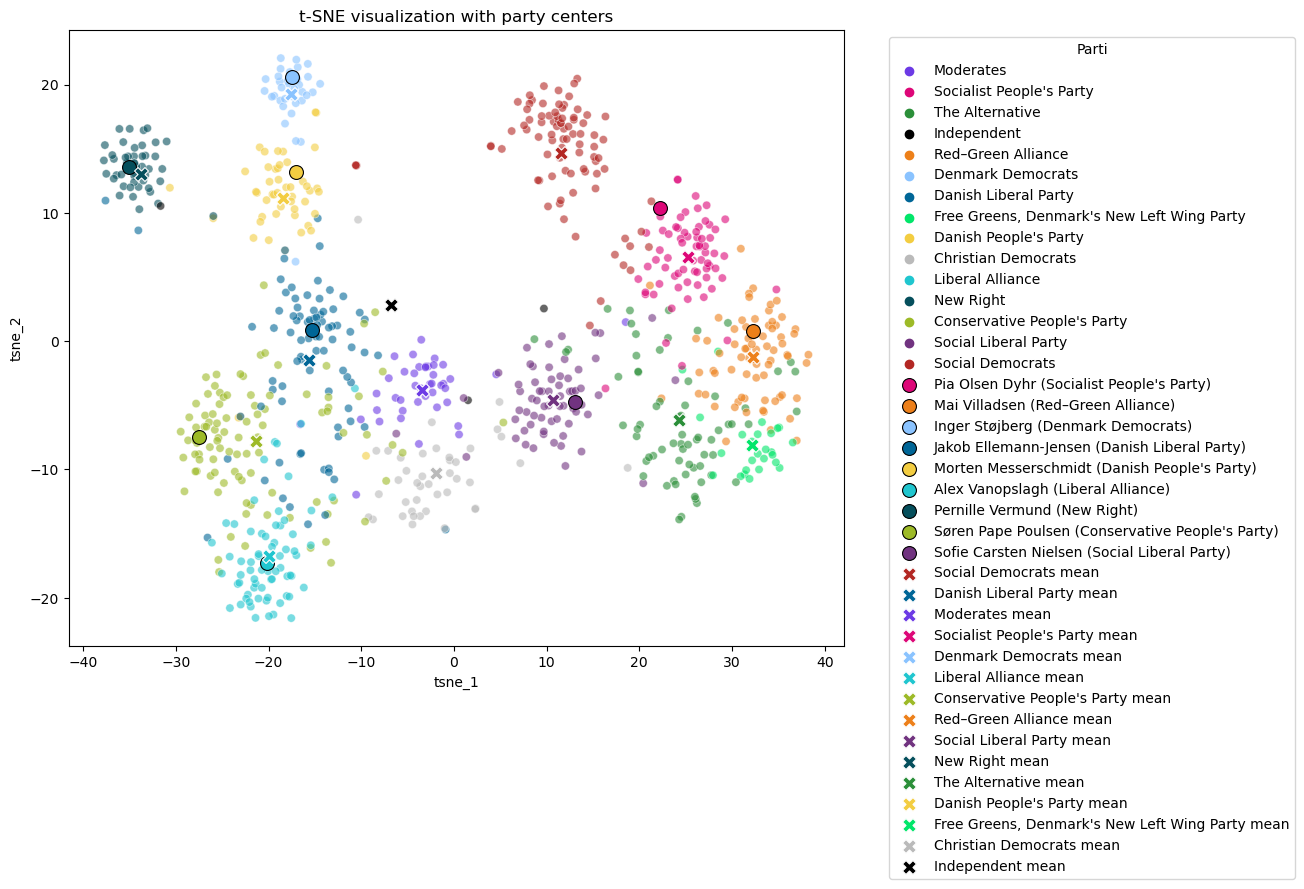

In [242]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='parti_english', data=df, palette=party_colors, alpha=0.6)
for party, leader in party_leaders.items():
    leader_position = df[df['navn'] == leader][['tsne_1', 'tsne_2']]
    if not leader_position.empty:
            sns.scatterplot(x=leader_position['tsne_1'], y=leader_position['tsne_2'], color=party_colors[party], s=100, edgecolor='black', label=f'{leader} ({party})')

for party, color in party_colors.items():
    party_center = df[df['parti_english'] == party][['tsne_1', 'tsne_2']].mean()
    sns.scatterplot(x=[party_center['tsne_1']], y=[party_center['tsne_2']], color=color, s=100, edgecolor='white', marker='X', label=f'{party} mean')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Parti')
plt.title('t-SNE visualization with party centers')
plt.show()

Even if it's not 100% clear from the graph above, the second axis seems to show the difference between socialists and democrats. Socialists being higher on the chart and Democrats being lower.

## K-Means

In [468]:
# We'll use k = 14 for K-means as independent candidates shouldn't really create their own cluster

len(df['parti'].unique()) - 1

14

In [535]:
k_cluster = KMeans(n_clusters=14, n_init=100, random_state=42, init='k-means++')
k_res = k_cluster.fit_predict(df[['pca_1', 'pca_2']])

In [536]:
centers = k_cluster.cluster_centers_

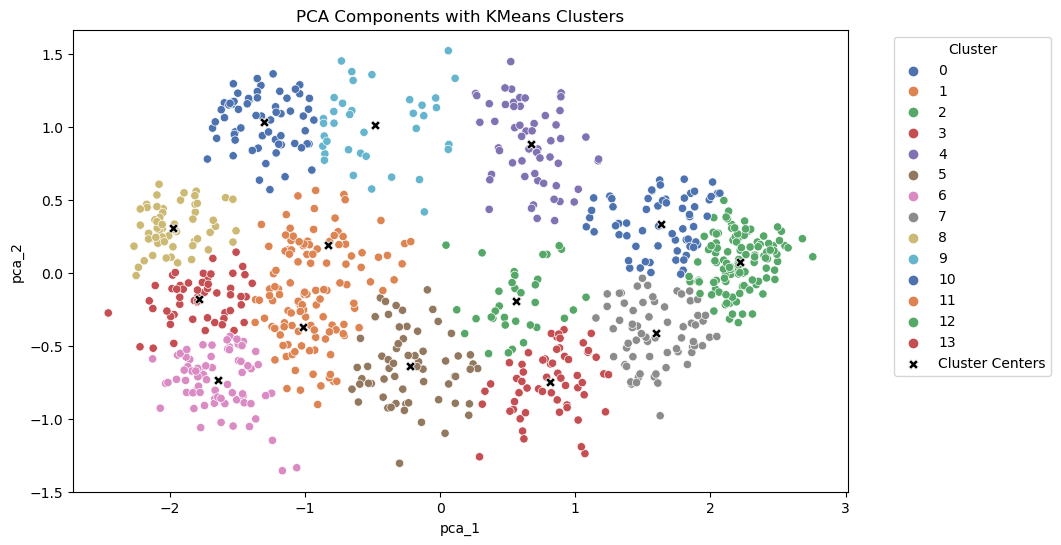

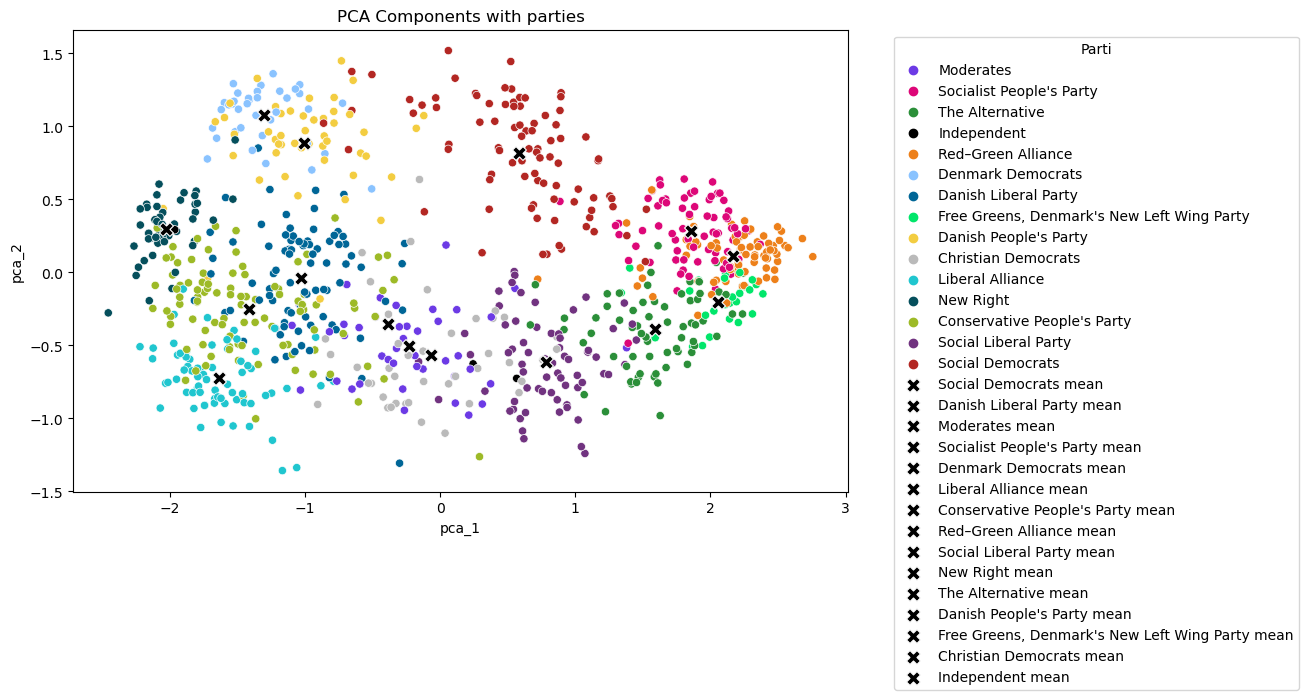

In [539]:
df['kmeans_cluster'] = k_res

palette = sns.color_palette("deep", n_colors=14)

# Scatter plot for K-means
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='kmeans_cluster', data=df, palette=palette)
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], s=50, c='black', edgecolor='white', label='Cluster Centers', marker='X')
plt.title('PCA Components with KMeans Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster')
plt.show()


party_center = df[df['parti_english'] == party][['pca_1', 'pca_2']].mean()

# Scatter plot for Parties
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='parti_english', data=df, palette=party_colors)

for party, color in party_colors.items():
    party_mean = df[df['parti_english'] == party][['pca_1', 'pca_2']].mean()
    sns.scatterplot(x=[party_mean['pca_1']], y=[party_mean['pca_2']], color='black', s=100, edgecolor='white', marker='X', label=f'{party} mean')

plt.title('PCA Components with parties')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Parti')
plt.show()


After comparing the actual parties to K-means clusters, surprisingly they show quite a lot of correlations, for how much do these parties ovelap with eachother. \
The main difference between clusters and actual parties seems to be in clusters, which have grouped some of the parties together and created some new ones in the center for more neutral candidates.

## Hierarchical clustering

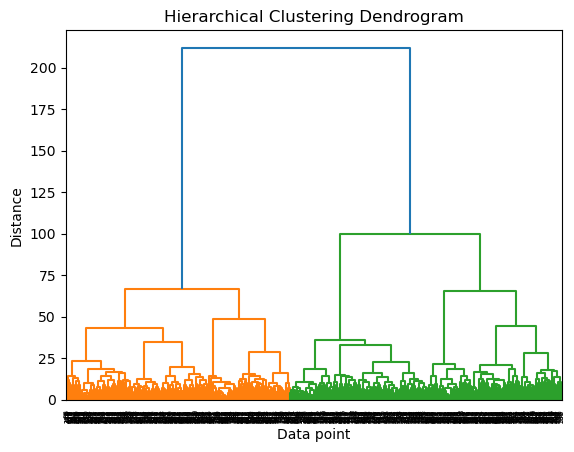

In [ ]:
Z = linkage(X.drop(columns="political_spectrum"), 'ward') 
  
dendrogram(Z)   
plt.title('Hierarchical Clustering Dendrogram') 
plt.xlabel('Data point') 
plt.ylabel('Distance')
plt.show()

Even though we already have our number of clusters predefined (14), it seems that the optimal number of clusters seems to be around 16.

In [529]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=14).fit(X.drop(columns="political_spectrum"))
df['hierarchical_cluster'] = hierarchical_clustering.labels_

hierarchical_clustering_pca = AgglomerativeClustering(n_clusters=14).fit(df[['pca_1', 'pca_2']])
df['hierarchical_cluster_pca'] = hierarchical_clustering.labels_

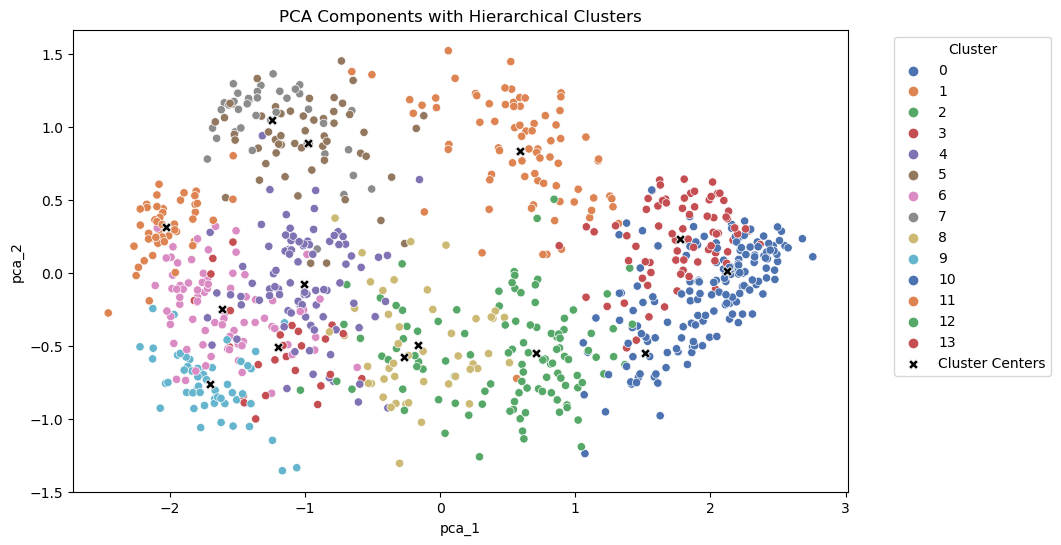

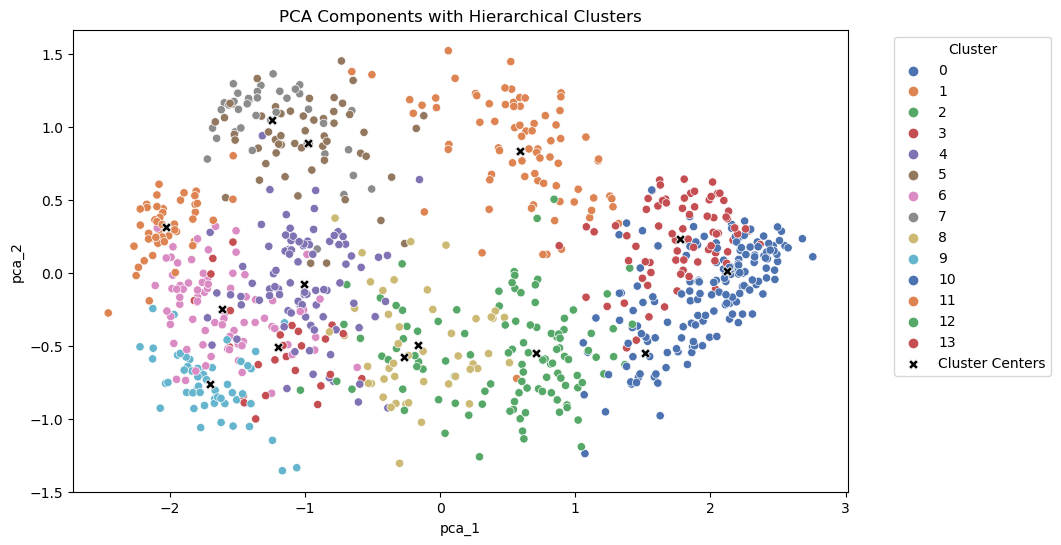

In [530]:
cluster_centers = df.groupby('hierarchical_cluster')[['pca_1', 'pca_2']].mean()
palette = sns.color_palette("deep", n_colors=len(cluster_centers))

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='hierarchical_cluster', data=df, palette=palette)
sns.scatterplot(x=cluster_centers['pca_1'], y=cluster_centers['pca_2'], s=50, c='black', edgecolor='white', label='Cluster Centers', marker='X')
plt.title('PCA Components with Hierarchical Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster')
plt.show()


cluster_centers = df.groupby('hierarchical_cluster_pca')[['pca_1', 'pca_2']].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='hierarchical_cluster_pca', data=df, palette=palette)
sns.scatterplot(x=cluster_centers['pca_1'], y=cluster_centers['pca_2'], s=50, c='black', edgecolor='white', label='Cluster Centers', marker='X')
plt.title('PCA Components with Hierarchical Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster')
plt.show()

It seems that hierarchical clustering has performed better than K-means when it comes to guessing the actual parties, it didn't group the parties too much and didn't create any in the middle. Whether it performes better at finding new possible parties is up for a debate and we did not invest further in this topic as we're not politicians. \
We've also tried to compare training the algorithm on all questions with training it only on PCA_1 and PCA_2. This showed identical results, and therefore it wouldn't make much sense to use all questions individually.

## DBSCAN

In [507]:
clustering = DBSCAN(eps=0.15, min_samples=10).fit(df[['pca_1', 'pca_2']])
df['dbscan_cluster'] = clustering.labels_

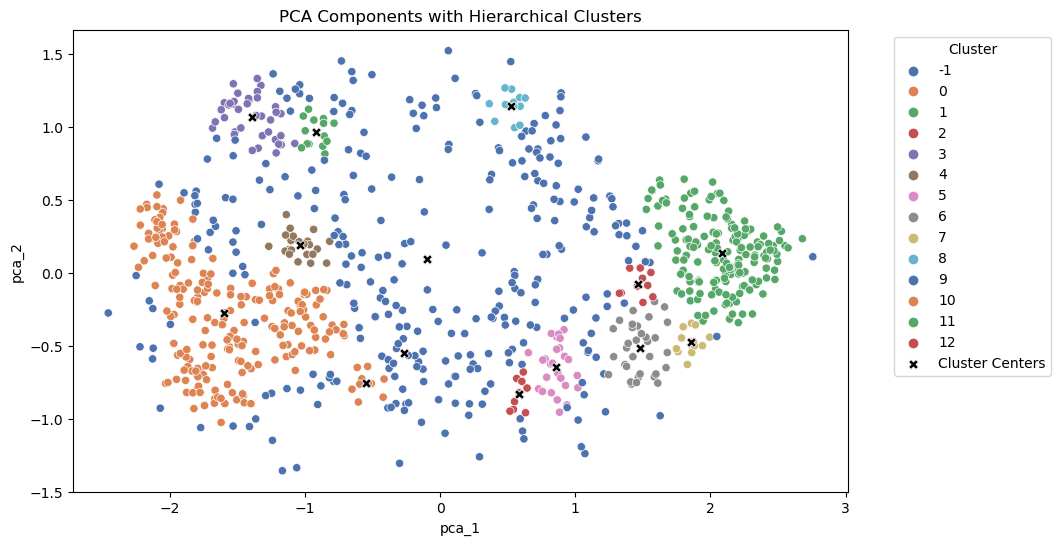

In [524]:
cluster_centers = df.groupby('dbscan_cluster')[['pca_1', 'pca_2']].mean()
palette = sns.color_palette("deep", n_colors=len(cluster_centers))

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='dbscan_cluster', data=df, palette=palette)
sns.scatterplot(x=cluster_centers['pca_1'], y=cluster_centers['pca_2'], s=50, c='black', edgecolor='white', label='Cluster Centers', marker='X')
plt.title('PCA Components with Hierarchical Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster')
plt.show()

In scikit learn documentation, DBSCAN is described as: "Good for data which contains clusters of similar density. This means that DBSCAN is an awful fit to our dataset, as its data is not clustered together, and the density varies very much. \
It probably would be possible to tweak the hyperparameters in a way where we could find good cluster, but that would probably take a lot of time. \
But we can create a conclusion nonetheless. It did find 2 very large groups on both the very righ and the very left, also it did find a few semi-large groups. \
Interestingly enough, most os the datapoints were handled as outliers, so camparing it to previous algorithms, DBSCAN actually didn't assign candidates in the middle to any cluster. But again, this could probably be changed by hyperparameters.

In [ ]:
# Way too many outliers
df.groupby('dbscan_cluster').size()

dbscan_cluster
-1     288
 0     211
 1     164
 2      10
 3      38
 4      23
 5      26
 6      33
 7      13
 8      13
 9      15
 10     10
 11     14
 12      9
dtype: int64

# Elected candidate analysis

In [297]:
elected = pd.read_excel("electeddata.xlsx")
elected.shape

(169, 53)

In [ ]:
print("The average age of an elected candidate:", elected['alder'].mean())
print("The median age of an elected candidate:", elected['alder'].median())

The average age of an elected: 45.0
The median age of an elected: 46.0


In [299]:
questions_overview = df.describe().T.reset_index(names='id')
questions_overview = pd.merge(left=questions_overview, right=questions, on='id')

In [300]:
# We can see that most controversial questions for elected candidates 
# were surrounding the mink case and refugees and immigrants

questions_overview.sort_values(by='std', ascending=False).head(10)

,id,count,mean,std,min,25%,50%,75%,max,header,question,header_eng
14,11a,867.0,-0.725490,1.474442,-2.0,-2.0,-1.0,1.0,2.0,Mink-sagen,Der har været alt for meget fokus på Mette Fre...,Mink Case
0,1a,867.0,-0.412918,1.454536,-2.0,-2.0,-1.0,1.0,2.0,Miljø og klima,"Oksekød bør pålægges en klimaafgift, således a...",Environment and Climate
3,2b,867.0,0.291811,1.438971,-2.0,-1.0,1.0,1.5,2.0,Hospitaler og sundhed,Cigaretter bør pålægges en ekstra afgift på 20...,Hospitals and Health
4,3a,867.0,0.685121,1.411368,-2.0,0.0,1.0,2.0,2.0,Udenrigs- og forsvarspolitik,Danmark bør bruge to procent af BNP på forsvar...,Foreign and Defense Policy
11,9a,867.0,-0.340254,1.410381,-2.0,-2.0,-1.0,1.0,2.0,Skole og uddannelse,Dele af SU’en på videregående uddannelser skal...,School and Education
1,1b,867.0,0.377163,1.368428,-2.0,-1.0,1.0,2.0,2.0,Miljø og klima,"De virksomheder, der udleder mest CO₂, skal be...",Environment and Climate
13,10a,867.0,0.490196,1.235851,-2.0,-1.0,1.0,1.0,2.0,Socialområdet,Det offentlige bruger i dag for mange penge på...,Social Affairs
16,12b,867.0,-0.422145,1.222147,-2.0,-2.0,0.0,0.0,2.0,Coronavirus,"Hvis coronasmitten stiger markant til vinter, ...",Coronavirus
5,4b,867.0,0.565167,1.187438,-2.0,0.0,1.0,1.0,2.0,Økonomi,Staten bør i højere grad kompensere danskerne ...,Economy
2,2a,867.0,0.843137,1.152699,-2.0,0.0,1.0,2.0,2.0,Hospitaler og sundhed,Folketinget bør afsætte midler målrettet et lø...,Hospitals and Health


In [301]:
# Confirming the previous point by taking standard deviation
questions_overview.groupby(['header_eng']).mean(numeric_only=True).sort_values(by='std', ascending=False)

,count,mean,std,min,25%,50%,75%,max
header_eng,,,,,,,,
Mink Case,867.0,-0.725490,1.474442,-2.0,-2.0,-1.0,1.00,2.0
Environment and Climate,867.0,-0.017878,1.411482,-2.0,-1.5,0.0,1.50,2.0
Foreign and Defense Policy,867.0,0.685121,1.411368,-2.0,0.0,1.0,2.00,2.0
Hospitals and Health,867.0,0.567474,1.295835,-2.0,-0.5,1.0,1.75,2.0
Social Affairs,867.0,0.490196,1.235851,-2.0,-1.0,1.0,1.00,2.0
School and Education,867.0,-0.188005,1.212041,-2.0,-1.5,-0.5,1.00,2.0
Economy,867.0,0.565167,1.187438,-2.0,0.0,1.0,1.00,2.0
Coronavirus,867.0,0.117647,1.125097,-2.0,-1.0,0.5,0.50,2.0
Energy Policy,867.0,0.837370,1.100110,-2.0,0.0,1.0,2.00,2.0


In [302]:
grouped = elected.groupby(['parti']).mean(numeric_only=True).describe().T.drop(index=['alder']).reset_index(names='id')

In [303]:
# Similary to the overall controversy, the most disagreed topics are refugees, 
# the mink case, and foreign and defence policy

grouped.sort_values(by='std', ascending=False).merge(questions, on='id')

,id,count,mean,std,min,25%,50%,75%,max,header,question,header_eng
0,6b,12.0,0.068202,1.620414,-2.000000,-1.803571,0.978261,1.166667,2.000000,Flygtninge og indvandrere,Det vil være en god idé at etablere et dansk a...,Refugees and Immigrants
1,11b,12.0,0.595994,1.617337,-1.916667,-1.218254,1.278571,1.916925,2.000000,Mink-sagen,"Det bør undersøges, om Mette Frederiksen kan s...",Mink Case
2,3b,12.0,-0.267058,1.611655,-2.000000,-1.628571,-0.775362,1.660714,1.888889,Udenrigs- og forsvarspolitik,Ulandsbistanden bør hæves.,Foreign and Defense Policy
3,6a,12.0,-0.328275,1.502263,-2.000000,-1.658333,-0.694940,1.203571,1.888889,Flygtninge og indvandrere,Den danske udlændingepolitik er for stram.,Refugees and Immigrants
4,10b,12.0,0.644119,1.477261,-1.928571,0.040373,1.100000,1.877232,2.000000,Socialområdet,"Den såkaldte Arne-pension, der giver mulighed ...",Social Affairs
5,7a,12.0,-0.322823,1.470259,-1.928571,-1.578571,-0.628571,0.839286,2.000000,Energipolitik,Indførelse af atomkraft i Danmark vil være et ...,Energy Policy
6,9a,12.0,-0.124833,1.410865,-1.928571,-1.628571,0.062112,1.110714,1.600000,Skole og uddannelse,Dele af SU’en på videregående uddannelser skal...,School and Education
7,1b,12.0,0.116994,1.332953,-2.000000,-0.628571,-0.017081,1.273810,2.000000,Miljø og klima,"De virksomheder, der udleder mest CO₂, skal be...",Environment and Climate
8,3a,12.0,0.760426,1.289372,-1.800000,0.479911,1.250000,1.600000,2.000000,Udenrigs- og forsvarspolitik,Danmark bør bruge to procent af BNP på forsvar...,Foreign and Defense Policy
9,11a,12.0,-0.784867,1.274248,-2.000000,-1.934783,-1.100000,0.233333,1.604167,Mink-sagen,Der har været alt for meget fokus på Mette Fre...,Mink Case
